# Self RAG




Self-Reflection RAG (Retrieval-Augmented Generation) is an advanced method combining retrieval-based and generation-based models to enhance the accuracy and reliability of generated outputs. In this approach, a model retrieves relevant documents or information (retrieval) and uses this data to inform and generate new content or responses (generation). The self-reflection aspect adds a layer where the model evaluates its own outputs to refine or improve them further, leading to more accurate and contextually appropriate results.

![ezgif.com-animated-gif-maker (1).gif](<attachment:ezgif.com-animated-gif-maker (1).gif>)

## Set Environment Vars and API Keys

In this notebook we will use Mixtral 8x7b from groq, you can follow these steps to get groq api key:
1. Open [groq](https://console.groq.com/login) and sign up/in
2. Go to [groq API keys page](https://console.groq.com/keys)
3. Press Create API Key and choose name for your API key 
4. Copy your key and paste it into `.env` file / pass it to `GROQ_API_KEY` enviroment variable or even pass as as variable to your model `llm = ChatGroq(api_key="your API key")`

In [10]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQQ_API_KEY")


## Retriever
 


We will use 3 awsome blogposts by **"Lilian Weng"** documents as our data to the retriever:

- [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/)
- [Prompt Engineering](https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/)
- [Adversarial Attacks on LLMs](https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/)

After loading the data, split it and store it in vectorstore to be our retriever

In [2]:
from pydantic import BaseModel, Field
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=hf_embeddings,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
e:\Programs\anaconda3\envs\LLMs\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## LLMs

Generate first LLM to check wether the retrieved documents relavent to the user's query or not 

- Create `GradeDocuments` class which inheret from `BaseModel` class
- The `binary_score` is simply `Field` with just one of two values `yes` (when the retrieved documents are related to the query) and `no` (when the retrieved documents are **NOT** related to the query)
- Create llm with structured output to insure the output always will follow `GradeDocuments` class 
- Create new chain to check the relation betweeen retrieved documents and the query using `GradeDocuments` 

In [11]:
### Retrieval Grader 

from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


Lets generate answer based on the retrieved documents

In [13]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In a LLM-powered autonomous agent system, the agent's brain is the LLM, which is complemented by several key components. Memory in this system consists of short-term and long-term modules. Short-term memory involves in-context learning, while long-term memory utilizes an external vector store for retaining and recalling information over extended periods. Additionally, there is a memory stream, an external database that records a comprehensive list of agents’ experience in natural language.


Generate second LLM to check wether the retrieved documents are Hallucinations or not 

- Create `GradeHallucinations` class which inheret from `BaseModel` class
- The `binary_score` is simply `Field` with just one of two values `yes` (when the retrieved documents are hallucinations) and `no` (when the retrieved documents are **NOT** hallucinations)
- Create llm with structured output to insure the output always will follow `GradeHallucinations` class 
- Create new chain to check the relation betweeen retrieved documents and the query using `GradeHallucinations` 

In [14]:
### Hallucination Grader 

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0,api_key=GROQ_API_KEY)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt 
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

Generate last LLM to check wether the retrieved documents address the user's query or not 

- Create `GradeAnswer` class which inheret from `BaseModel` class
- The `binary_score` is simply `Field` with just one of two values `yes` (when the answer addresses the user's query) and `no` (when the answer **DIDN'T** addresses the user's query)
- Create llm with structured output to insure the output always will follow `GradeDocuments` class 
- Create new chain to check the relation betweeen retrieved documents and the query using `GradeDocuments` 

In [15]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(temperature=0,api_key=GROQ_API_KEY)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

GradeAnswer(binary_score='yes')

In [17]:
### Question Re-writer

# LLM 
llm = ChatGroq(temperature=0,api_key=GROQ_API_KEY)

# Prompt 
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying sematic intent / meaning. Just say the question. I dont need any explanation just question is enough"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'"What is the concept of agent memory and how does it function in a vector database context?"'

## Graph 



### Graph state

Create simple `GraphState` class which is simply dictionary with 3 keys : 
- `question`: Contain the current question / query
- `generation`: contain the current response / generations 
- `documents`: contain the retrieved documents from our vectorstore

In [18]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents 
    """
    question : str
    generation : str
    documents : List[str]

### Create functions for generating useful answer

We will create 5 functions to get useful answer 

1. `retrieve` : Simply it takes our current state (instance of `GraphState` class), extract `question` from that state then retrieve documents based on that question.
2. `generate` : Based on the `question` and the `document` list in our `state` variable , use them to generate response / answer.
3. `grade_documents` : Iterate over the retrieve documents , drop unrelavent documents , keep only the relavent ones.
4. `transform_query` : Based on the input query , transform it to produce a better question.
5. `decide_to_generate` : after filtering the documents , if there any relavent documents use them to generate response , and if not , don't generate.
6. `grade_generation_v_documents_and_question` : check if the respone is hallucinations or not , if hallucinations re-generate new response and if not, check if the response addresses the query or not , if addressed we are done and if not, transform the query.

In [19]:
### Nodes

from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Build Graph



Let's build our graph which is in the following image

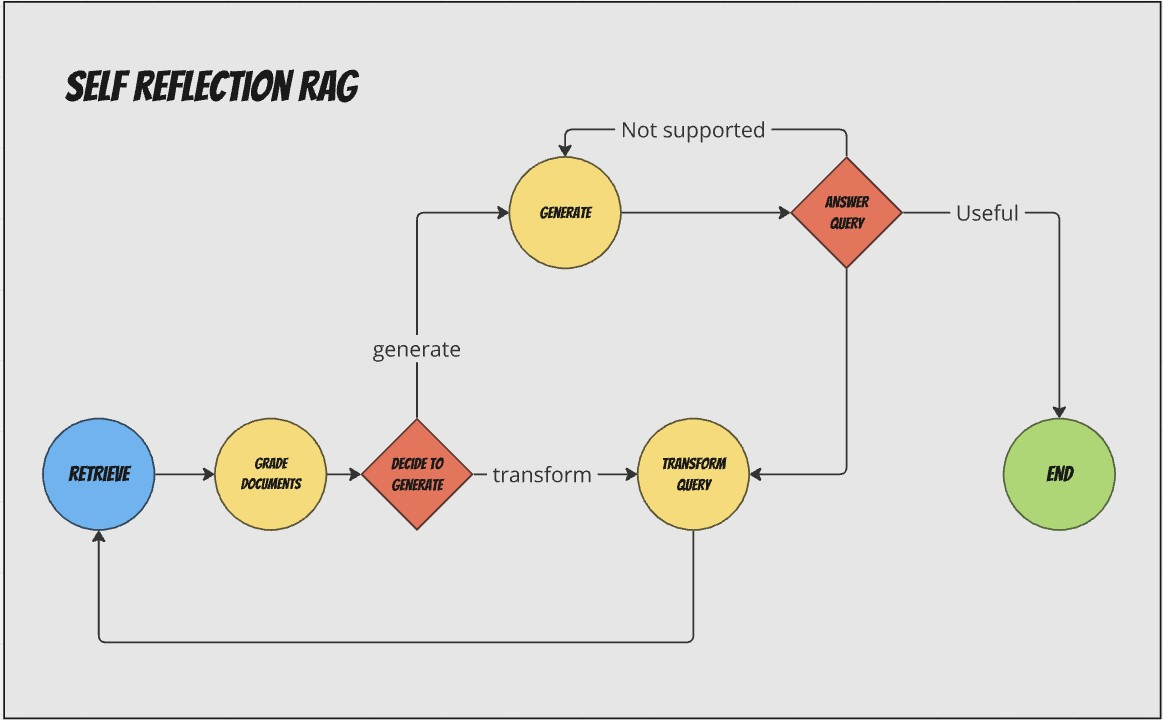

In [20]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae
workflow.add_node("transform_query", transform_query) # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

### Test the Self-reflection RAG

let's test our RAG

you can always type your own question 

```python
inputs = {"question": "Add your question here"}

```

In [21]:
from pprint import pprint

# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('In a LLM-powered autonomous agent system, there are two main types of '
 'memory: short-term and long-term memory. Short-term memory is used for '
 'in-context learning, while long-term memory, supported by an external vector '
 'store, allows the agent to retain and recall information over extended '
 'periods. Additionally, the agent can use external APIs for tool use, '
 'accessing current information, code execution, and proprietary information '
 'sources.')


In [18]:
inputs = {"question": "Explain how chain of thought prompting works?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node '__end__':"
'\n---\n'
('Chain of thought prompting works by providing a series of prompts or '
 'demonstrations to guide the model through a reasoning process. This method '
 'involves iteratively constructing thought processes by asking follow-up '
 'questions or exploring multiple reasoning possibilities at each step. '
 'External search queries and relevant content from sources like Wikipedia can '
 'be integrated into the context to enhance the chain of thought reasoning.')


In [22]:
value["generation"]

'In a LLM-powered autonomous agent system, there are two main types of memory: short-term and long-term memory. Short-term memory is used for in-context learning, while long-term memory, supported by an external vector store, allows the agent to retain and recall information over extended periods. Additionally, the agent can use external APIs for tool use, accessing current information, code execution, and proprietary information sources.'